# MovieLens Exploratory Data Analysis | Germán Germán De Souza MBD

# Pyspark environment setup

In [109]:
#Maybe you will need to install tabulate and restart the kernell before running all cells "pip install tabulate"
import findspark
findspark.init()

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *
from IPython.display import display, Markdown
from pyspark.sql.functions import *
from pyspark.sql.window import Window

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

# Data sources, schema definition & assignation of objects

**In this section we will also provide the size of our 3 datasets.**

In [108]:
# Assigning appropiate schema for each column within different csv files
dfmoviesSchema = StructType(\
                     [StructField("MovieID",IntegerType(),True),\
                      StructField("Title",StringType(),True),\
                      StructField("Genres",StringType(),True)])

dfratingsSchema = StructType(\
                     [StructField("UserID",IntegerType(),True),\
                      StructField("MovieID",IntegerType(),True),\
                      StructField("Rating",IntegerType(),True),\
                      StructField("Timestamp",TimestampType(),True)])

dfusersSchema = StructType(\
                     [StructField("UserID",IntegerType(),True),\
                      StructField("Gender",StringType(),True),\
                      StructField("Age",StringType(),True),\
                      StructField("Occupation",StringType(),True),\
                      StructField("Zip-code",StringType(),True)])


# Importing all files to the environment as objects dfmovies, dfratings, dfusers and applying the corresponding schema
# For each Spark object
dfmovies = spark.read.schema(dfmoviesSchema) \
                 .option("inferSchema", "true") \
                 .option("header", "true") \
                 .option("sep",";") \
                 .csv("movies.csv")

dfratings = spark.read.schema(dfratingsSchema) \
                 .option("inferSchema", "true") \
                 .option("header", "true") \
                 .option("sep",",") \
                 .csv("ratings.csv")

dfusers = spark.read.schema(dfusersSchema) \
                 .option("inferSchema", "true") \
                 .option("header", "true") \
                 .option("sep",";") \
                 .csv("users.csv")
display(Markdown("The dataframes which we will analyse are **'dfratings','dfusers' and 'dfmovies'**. These datasets have around **%d ratings** from **%d users** and **%d movies**." % (dfratings.count(),dfusers.count(),dfmovies.count())))
display(Markdown("Before conducting our Exploratory analysis, we have to make sure that our datasets have the **right structure type for each of the columns** and that there are **no null values**."))

The dataframes which we will analyse are **'dfratings','dfusers' and 'dfmovies'**. These datasets have around **1000209 ratings** from **6040 users** and **3883 movies**.

Before conducting our Exploratory analysis, we have to make sure that our datasets have the **right structure type for each of the columns** and that there are **no null values**.

# Dataset metadata analysis

## A. Displaying Schema (Preliminary check on if our dataframes have the appropiate schema)

In [110]:
# Checking if the schemas which we have configured are appropiately designated
dfratings.printSchema()
dfusers.printSchema()
dfmovies.printSchema()

root
 |-- UserID: integer (nullable = true)
 |-- MovieID: integer (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)

root
 |-- UserID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Zip-code: string (nullable = true)

root
 |-- MovieID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Genres: string (nullable = true)



**As we can see, the dataframes that we are going to work with the schema has been properly assigned for each dataframe.**

## B. Data entities, metrics and dimensions

In my dataset, I have identified the following elements:

* **Entities:** Movie Ratings (dimension), Platform Users (dimension), Platform Movies (dimension)
* **Metrics:** Ratings (average ratings), Timestamp (segmented by day, month and year), Occupation (3 different categories), Genres (already segmented in its corresponding column), Age (already segmented in its corresponding column).
* **Dimensions:** Movie Title, Gender, Zip-code

## C. Column categorization

Fortunately, **the datasets have been already categorised in their corresponding family** and **therefore there is no need of stablishing this.**

## D. Basic profiling based on the 3 different spark objects


### (D-1) Checking if all the fields in the different spark objects don't have NULL's

In [111]:
#Identify if there are null values in all of our datasets "dfratings" "dfmovies" "dfusers"
display(Markdown("**Pre-check before EDA**"))
print("Ratings Dataframe") #"dfratings"
dfratings.select([count(when(col(column).isNull(), column)).alias(column) for column in ["UserID","MovieID","Rating","Timestamp"]]).show()
print("Movies Dataframe") #dfmovies"
dfmovies.select([count(when(col(column).isNull(), column)).alias(column) for column in ["MovieID","Title","Genres"]]).show()
print("Users Dataframe") #"dfusers"
dfusers.select([count(when(col(column).isNull(), column)).alias(column) for column in ["UserID","Gender","Age","Occupation","Zip-code"]]).show()
display(Markdown("**As we can see in our Movies Dataframe, there is only one movie which doesnt have assigned genres. It is therefore that we will identify that MovieID so we can change the null for its corresponding genre.**"))
dfmovies.filter("Genres is null").show()
display(Markdown("**Movie 3845 labeled as 'And God Created Woman' is categorised as a 'Drama | Romance' genre. We will substitute this categorisation from the previous one.**"))
dfmovies = dfmovies.na.fill("Drama|Romance")
dfmovies.filter(dfmovies.MovieID==3845).show()
display(Markdown("**As we can see, the movie has its assigned genre, which gives us the green light to continue with our analysis**"))

**Pre-check before EDA**

Ratings Dataframe
+------+-------+------+---------+
|UserID|MovieID|Rating|Timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+

Movies Dataframe
+-------+-----+------+
|MovieID|Title|Genres|
+-------+-----+------+
|      0|    0|     1|
+-------+-----+------+

Users Dataframe
+------+------+---+----------+--------+
|UserID|Gender|Age|Occupation|Zip-code|
+------+------+---+----------+--------+
|     0|     0|  0|         0|       0|
+------+------+---+----------+--------+



**As we can see in our Movies Dataframe, there is only one movie which doesnt have assigned genres. It is therefore that we will identify that MovieID so we can change the null for its corresponding genre.**

+-------+--------------------+------+
|MovieID|               Title|Genres|
+-------+--------------------+------+
|   3845|And God Created W...|  null|
+-------+--------------------+------+



**Movie 3845 labeled as 'And God Created Woman' is categorised as a 'Drama | Romance' genre. We will substitute this categorisation from the previous one.**

+-------+--------------------+-------------+
|MovieID|               Title|       Genres|
+-------+--------------------+-------------+
|   3845|And God Created W...|Drama|Romance|
+-------+--------------------+-------------+



**As we can see, the movie has its assigned genre, which gives us the green light to continue with our analysis**

### (D-2) Time related column (splitting "timestamp" from "dfratings")

In [139]:
dfratings_analysis = dfratings\
                            .withColumn("Date", to_date("Timestamp"))\
                            .select("Date","Timestamp")

print ("Summary of the 'Timestamp' column within 'dfratings' - segmented in three different categories Year, Month and Day:")
dfratings_analysis = dfratings_analysis\
                                    .withColumn("Year",split(dfratings_analysis["Date"], "-").getItem(0))\
                                    .withColumn("Month",split(dfratings_analysis["Date"], "-").getItem(1))\
                                    .withColumn("Day",split(dfratings_analysis["Date"], "-").getItem(2))\
                                    .select("Year","Month","Day")
dfratings_analysis.summary().show()

print ("Different elements in the time realted column")
dfratings_analysis\
                .select([countDistinct(column).alias(column) for column in ["Year","Month","Day"]])\
                .show()

print ("Most and least frequent occurrences split into Months, Days and Years:")
frequentmonth = dfratings_analysis.groupBy("Month").agg(count(lit(1)).alias("Total"))
frequentday = dfratings_analysis.groupBy("Day").agg(count(lit(1)).alias("Total"))
frequentyear = dfratings_analysis.groupBy("Year").agg(count(lit(1)).alias("Total"))

mostfrequentmonth = frequentmonth.orderBy(col("Total").desc()).first()
leastfrequentmonth = frequentmonth.orderBy(col("Total").asc()).first()
mostfrequentday = frequentday.orderBy(col("Total").desc()).first()
leastfrequentday = frequentday.orderBy(col("Total").asc()).first()
mostfrequentyear = frequentyear.orderBy(col("Total").desc()).first()
leastfrequentyear = frequentyear.orderBy(col("Total").asc()).first()

display(Markdown("""
| %s | %s | %s | %s | %s | %s |
|----|----|----|----|----|----|
| %s | %s | %s | %s | %s | %s |
""" % ("leastfrequentmonth", "mostfrequentmonth", "leastfrequentday", "mostfrequentday", "leastfrequentyear", "mostfrequentyear", \
       "%s (%d occurrences)" % (leastfrequentmonth["Month"], leastfrequentmonth["Total"]), \
       "%s (%d occurrences)" % (mostfrequentmonth["Month"], mostfrequentmonth["Total"]), \
       "%s (%d occurrences)" % (leastfrequentday["Day"], leastfrequentday["Total"]), \
       "%s (%d occurrences)" % (mostfrequentday["Day"], mostfrequentday["Total"]), \
       "%s (%d occurrences)" % (leastfrequentyear["Year"], leastfrequentyear["Total"]), \
       "%s (%d occurrences)" % (mostfrequentyear["Year"], mostfrequentyear["Total"]))))

Summary of columns within 'dfratings' Year, Month and Day:
+-------+-------------------+------------------+-----------------+
|summary|               Year|             Month|              Day|
+-------+-------------------+------------------+-----------------+
|  count|            1000209|           1000209|          1000209|
|   mean| 2000.1262036234427| 8.713123957092968|15.42191481980266|
| stddev|0.42242419513457724|2.7162044032711234|8.882599414656145|
|    min|               2000|                01|               01|
|    25%|             2000.0|               7.0|              7.0|
|    50%|             2000.0|               9.0|             17.0|
|    75%|             2000.0|              11.0|             22.0|
|    max|               2003|                12|               31|
+-------+-------------------+------------------+-----------------+

Different elements in the time realted column
+----+-----+---+
|Year|Month|Day|
+----+-----+---+
|   4|   12| 31|
+----+-----+---+

Most


| leastfrequentmonth | mostfrequentmonth | leastfrequentday | mostfrequentday | leastfrequentyear | mostfrequentyear |
|----|----|----|----|----|----|
| 03 (8454 occurrences) | 11 (295161 occurrences) | 31 (16398 occurrences) | 20 (79085 occurrences) | 2003 (3348 occurrences) | 2000 (904721 occurrences) |


**It was expected that the least frequent year was 2003. This is due to the lack of data in 2003 (only from January 2003 until March 2003 - We will further see it in our analysis below).**

### (D-3) Basic profiling for the rest of elements in "dfratings"

In [149]:
print("Summary of the rest of columns in dfratings:")
dfratings\
        .select("UserID","MovieID", "Rating")\
        .summary()\
        .show()

print("Distinct 'UserID's' Movies and Ratings:")
dfratings\
        .select([countDistinct(column).alias(column) for column in ["UserID","MovieID", "Rating"]])\
        .show()

print ("Most and least frequent occurrences in UserID, MovieID and Ratings:")
frequentuser = dfratings.groupBy("UserID").agg(count(lit(1)).alias("Total"))
frequentmovie = dfratings.groupBy("MovieID").agg(count(lit(1)).alias("Total"))
frequentrating = dfratings.groupBy("Rating").agg(count(lit(1)).alias("Total"))

mostfrequentuser = frequentuser.orderBy(col("Total").desc()).first()
leastfrequentuser = frequentuser.orderBy(col("Total").asc()).first()
mostfrequentmovie = frequentmovie.orderBy(col("Total").desc()).first()
leastfrequentmovie = frequentmovie.orderBy(col("Total").asc()).first()
mostfrequentrating = frequentrating.orderBy(col("Total").desc()).first()
leastfrequentrating = frequentrating.orderBy(col("Total").asc()).first()

display(Markdown("""
| %s | %s | %s | %s | %s | %s |
|----|----|----|----|----|----|
| %s | %s | %s | %s | %s | %s |
""" % ("leastfrequentuser", "mostfrequentuser", "leastfrequentmovie", "mostfrequentmovie", "leastfrequentrating", "mostfrequentrating", \
       "%s (%d occurrences)" % (leastfrequentuser["UserID"], leastfrequentuser["Total"]), \
       "%s (%d occurrences)" % (mostfrequentuser["UserID"], mostfrequentuser["Total"]), \
       "%s (%d occurrences)" % (leastfrequentmovie["MovieID"], leastfrequentmovie["Total"]), \
       "%s (%d occurrences)" % (mostfrequentmovie["MovieID"], mostfrequentmovie["Total"]), \
       "%s (%d occurrences)" % (leastfrequentrating["Rating"], leastfrequentrating["Total"]), \
       "%s (%d occurrences)" % (mostfrequentrating["Rating"], mostfrequentrating["Total"]))))

print("Least Favourite movie is:") 
dfmovies.filter("MovieID == 2235").show()

Summary of the rest of columns in dfratings:
+-------+------------------+------------------+-----------------+
|summary|            UserID|           MovieID|           Rating|
+-------+------------------+------------------+-----------------+
|  count|           1000209|           1000209|          1000209|
|   mean| 3024.512347919285|1865.5398981612843|3.581564453029317|
| stddev|1728.4126948999121| 1096.040689457259|1.117101845373239|
|    min|                 1|                 1|                1|
|    25%|              1506|              1030|                3|
|    50%|              3069|              1835|                4|
|    75%|              4476|              2770|                4|
|    max|              6040|              3952|                5|
+-------+------------------+------------------+-----------------+

Distinct 'UserID's' Movies and Ratings:
+------+-------+------+
|UserID|MovieID|Rating|
+------+-------+------+
|  6040|   3706|     5|
+------+-------+------+

M


| leastfrequentuser | mostfrequentuser | leastfrequentmovie | mostfrequentmovie | leastfrequentrating | mostfrequentrating |
|----|----|----|----|----|----|
| 2488 (20 occurrences) | 4169 (2314 occurrences) | 2235 (1 occurrences) | 2858 (3428 occurrences) | 1 (56174 occurrences) | 4 (348971 occurrences) |


Least Favourite movie is:
+-------+--------------------+---------+
|MovieID|               Title|   Genres|
+-------+--------------------+---------+
|   2235|One Man's Hero (1...|Drama|War|
+-------+--------------------+---------+



**Small note to make: Surprisingly, there are 3883 movies in total (according to "dfmovies") and Users have watched 3706. Meaning that there are still 177 movies that haven't been reviewed yet by any of the users.**

**The least frequent user has watched 20 movies and the most active one has watched 2,314 movies**

**The most famous movie is "American Beauty" with 3,428 viewers and the least was "One Man's Hero" with 1 viewer**

### (D-3) Basic profiling join of "dfratings" and "dfmovies"

In [164]:
print("Basic Ratings Statistics on different movie genre categories:")
dfratings\
        .join(dfmovies, dfratings.MovieID==dfmovies.MovieID)\
        .select("Genres","Rating")\
        .withColumn("Genres", explode(split("Genres", "[|]")))\
        .groupBy("Genres")\
        .agg(count("Rating").alias("MovieCount"),\
             round(avg("Rating"),2).alias("AvgRating"),\
             min("Rating").alias("MinRating"),\
             max("Rating").alias("MaxRating"),\
             round(stddev("Rating"),2).alias("StdDevRating"))\
        .orderBy(desc("MovieCount")).show()

Basic Ratings Statistics on different movie genre categories:
+-----------+----------+---------+---------+---------+------------+
|     Genres|MovieCount|AvgRating|MinRating|MaxRating|StdDevRating|
+-----------+----------+---------+---------+---------+------------+
|     Comedy|    356580|     3.52|        1|        5|        1.12|
|      Drama|    354529|     3.77|        1|        5|        1.05|
|     Action|    257457|     3.49|        1|        5|        1.13|
|   Thriller|    189680|     3.57|        1|        5|        1.11|
|     Sci-Fi|    157294|     3.47|        1|        5|        1.16|
|    Romance|    147551|     3.61|        1|        5|        1.07|
|  Adventure|    133953|     3.48|        1|        5|        1.13|
|      Crime|     79541|     3.71|        1|        5|        1.08|
|     Horror|     76386|     3.22|        1|        5|        1.23|
| Children's|     72186|     3.42|        1|        5|        1.16|
|        War|     68527|     3.89|        1|        5|

**From the chart above we can clearly observe the following: (1) The genre with the highest standard deviation and the lowest average rating is Horror. (2) Drama has a high rating and a low standard deviation compared to the other genres. It might be worth analysing these genres further (More analysis on those below).**

# EDA MovieLens Datasets

## (1) "Dfmovies" Dataframe Analysis

### (1.1) Movies Genre Distribution:

> *- Which are the most frequent Genres within the platform?*

> *- What is the percentage split between the Genres? Is it well compensated? Should there be more different Genres?*


Chart 1 - Genre Percentage Split for films within the platform
+-----------+-----+----------------------+
|     Genres|count|PercentageDistPerGenre|
+-----------+-----+----------------------+
|      Drama| 1603|                 25.01|
|     Comedy| 1200|                 18.72|
|     Action|  503|                  7.85|
|   Thriller|  492|                  7.68|
|    Romance|  472|                  7.36|
|     Horror|  343|                  5.35|
|  Adventure|  283|                  4.42|
|     Sci-Fi|  276|                  4.31|
| Children's|  251|                  3.92|
|      Crime|  211|                  3.29|
|        War|  143|                  2.23|
|Documentary|  127|                  1.98|
|    Musical|  114|                  1.78|
|    Mystery|  106|                  1.65|
|  Animation|  105|                  1.64|
|    Fantasy|   68|                  1.06|
|    Western|   68|                  1.06|
|  Film-Noir|   44|                  0.69|
+-----------+-----+---------------

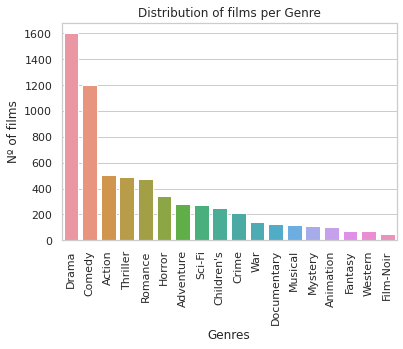

In [170]:
# Genre Distribution (Identify which is the most viewed genre)
# 1. We are creating a new object with solely the columns "genres" and "moviecount". This will enable us to identify the number of movies per genre that exists in the platform.
genrepref = dfmovies\
                    .withColumn("Genres", explode(split("Genres","[|]")))\
                    .groupBy("Genres")\
                    .count()\
                    .sort(desc("count"))

# 2. This code chunck is for the barplot below. It shows the data that we have stored in "genrepref" (genre preference)
hello = genrepref.toPandas()
sns.set_theme(style="whitegrid")
g = sns.barplot(x="Genres", y="count", data=hello)
g = (g.set_xticklabels(g.get_xticklabels(), rotation=90))
g = plt.xlabel("Genres")
g = plt.ylabel("Nº of films")
g = plt.title("Distribution of films per Genre")
plt.savefig("test.svg", format="svg")

# 3. This section returns the data in "genrepref" and computes the percentage split for each genre
print("Chart 1 - Genre Percentage Split for films within the platform")
genrepref\
        .withColumn("PercentageDistPerGenre", round((col("count")/sum("count").over(Window.partitionBy()))*100,2))\
        .show()

**Following the data shown in chart 1, Drama and Comedy holds over 44% out of all the films in the platform, clearly representing a dominance in the platform. It would be interesting to analyse the distribution of ratings in the different genres.**

### (1.2) Genre split of the top 10 movies from the platform (Popular movies genre analysis):

> *- Which are the top 10 most viewed movies within the platform?*

> *- Is there a specific genre pattern in the top 10 movies? Is there a specific Genre which is highly viewed?*


In [21]:
# 1. We create an object with all the necessary data for the different charts which we will execute below.
top10analysis = dfratings\
                            .groupBy("MovieID")\
                            .count()\
                            .join(dfmovies, dfratings.MovieID==dfmovies.MovieID)\
                            .sort(desc("count"))\
                            .drop(dfmovies.MovieID)\
                            .limit(10)\
                            .withColumn("Genres", explode(split("Genres", "[|]")))

# 2. We use the data to perform the Top 10 Movies Genre Analysis Inspection
print("Chart 2 - Top 10 most viewed movies (Genre classification)")
top10analysis_1 = top10analysis\
                                .groupBy("Genres")\
                                .count()\
                                .sort(desc("count"))\
                                .withColumnRenamed("count","Top10RatedMoviesGenres")\
                                .show()
top10analysis_1

# 3. We use the data to perform the Top 10 most viewed movies from 2000 until 2003
print("Chart 3 - Top 10 most viewed movies (2000-2003)")
top10analysis_2 = top10analysis\
                                .select("Title","MovieID","count")\
                                .distinct()\
                                .withColumnRenamed("count","Top10RatedMoviesViews")\
                                .show()
top10analysis_2

Chart 2 - Top 10 most viewed movies (Genre classification)
+---------+----------------------+
|   Genres|Top10RatedMoviesGenres|
+---------+----------------------+
|   Action|                     7|
|   Sci-Fi|                     7|
|Adventure|                     4|
|    Drama|                     4|
|      War|                     3|
| Thriller|                     3|
|   Comedy|                     2|
|  Fantasy|                     1|
|  Romance|                     1|
+---------+----------------------+

Chart 3 - Top 10 most viewed movies (2000-2003)
+--------------------+-------+---------------------+
|               Title|MovieID|Top10RatedMoviesViews|
+--------------------+-------+---------------------+
|American Beauty (...|   2858|                 3428|
|Star Wars: Episod...|    260|                 2991|
|Star Wars: Episod...|   1196|                 2990|
|Star Wars: Episod...|   1210|                 2883|
|Jurassic Park (1993)|    480|                 2672|
|Saving Priva

**From the data in chart 2, we can clearly state that Action, Sci-Fi, Adventure and Drama are some of the most popular Genres for users within the platform.**

**This completely aligns with our insights from section "(1.1) Movies Genre Distribution", clearly reaffirming their popularity compared to other movie genres which don't appear in chart 2.**

**Although, this insight is evident, I am intrigued in pursuing further analysis on average movie ratings on different genres. Maybe, this will help us to identify which genre we have to reinforce in order to increase genre variety and increasing the likelyhood of user retention.**

------

## (2) "Dfratings" Dataframe Analysis 

### (2.1) Average Ratings Distribution for the Top 10 Genres with the most movies:

> *- Which genres has the best average rating score? How is the distribution of each genre? Is the dispersion higher in different Genre and which one is the most stable?*

Chart 4 - Summary Statistics of each Genre Category
+----+------------+---------+---------+----------+---------+---------+---------+---------+---------+
|    | Genres     |   count |    mean |      std |     min |     25% |     50% |     75% |     max |
+====+============+=========+=========+==========+=========+=========+=========+=========+=========+
|  7 | Drama      |    1493 | 3.41533 | 0.610467 | 1       | 3.1     | 3.5     | 3.84127 | 5       |
+----+------------+---------+---------+----------+---------+---------+---------+---------+---------+
|  4 | Comedy     |    1163 | 3.15992 | 0.65199  | 1       | 2.73071 | 3.20202 | 3.66667 | 5       |
+----+------------+---------+---------+----------+---------+---------+---------+---------+---------+
|  0 | Action     |     495 | 3.0983  | 0.65157  | 1.28571 | 2.6538  | 3.15108 | 3.5635  | 4.6087  |
+----+------------+---------+---------+----------+---------+---------+---------+---------+---------+
| 15 | Thriller   |     485 | 3.22594 |

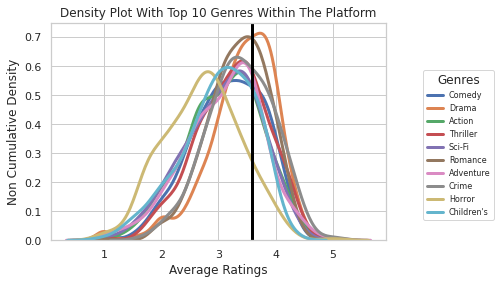

In [176]:
# Ratings Analysis
# This data will be necessary to properly execute the averages depending on the "genres_unique" values. Also, we need this for the chart above which we used pandas describe statistics.
ratings = dfratings\
                    .join(dfmovies, dfratings.MovieID==dfmovies.MovieID)\
                    .drop(dfratings.MovieID)\
                    .select("MovieID","Rating","Genres")\
                    .withColumn("Genres", explode(split("Genres","[|]")))\
                    .groupBy("MovieID","Genres").agg(avg("Rating"))\
                    .withColumnRenamed("avg(Rating)","AvgRatings")\
                    .toPandas()

# This is necessary to create "genres_unique".
ratings_2 = dfratings\
                    .join(dfmovies, dfratings.MovieID==dfmovies.MovieID)\
                    .select("Rating","Genres")\
                    .withColumn("Genres", explode(split("Genres","[|]")))

#This will be used for the iterative forloop to plot the different distributions. Instead of hardcoding a list of all possible genres, I found a way of extracting all the distinct genres and insert them into a list automatically.
genres_unique = ratings_2\
                        .select("Genres")\
                        .groupBy("Genres")\
                        .count()\
                        .sort(desc("count"))\
                        .select("Genres")\
                        .limit(10)\
                        .rdd.flatMap(list)\
                        .collect()

#This section creates the chart below by using the data from the pandas dataframe.
print("Chart 4 - Summary Statistics of each Genre Category")
summary = ratings.groupby("Genres")["AvgRatings"].describe().reset_index()
summary = summary.sort_values(by="count",ascending=False)
print(summary.iloc[0:10,:].to_markdown(tablefmt="grid"))


#This section creates the graph showing the different average ratings distributions per genre.
for i in genres_unique:
    subset = ratings[ratings["Genres"]==i]
    sns.distplot(subset["AvgRatings"], hist = False, kde = True, kde_kws = {"linewidth":3, "linestyle":"solid"},label = i)
    
plt.legend(bbox_to_anchor=(1.1, 0.8), loc='upper left', prop={'size': 8}, title = 'Genres')
plt.axvline(x=3.583,linewidth=3, color='black')
plt.title('Density Plot With Top 10 Genres Within The Platform')
plt.xlabel('Average Ratings')
plt.ylabel('Non Cumulative Density')
plt.savefig("test1.svg", format="svg")
print("")

**As we can observe in the graph above, the genre with best overall ratings which we can absolutely confirm is Drama. This genre has the highest ratings compared to the other top ten genres with most movies. Drama has the best overall average ratings, not only because it has a higher average rating than the other top ten genres with most movies, but also because it is the only genre that also has the highest number of movies within the platform. Drama is highly stable Genre.**

**Conversely, Horror it is seen to be highly dispersed compared to other genres (Amplitude of gaussian distribution is widder than any other popular genre). This means that this Genre is highly unstable as there is a high variability in their ratings. It could be suggested to the platform to upload high quality horror movies, in order to decrease variability and increase average horror movies ratings.**

### (2.2) Average Ratings Trend Along the Years for the Top 10 Genres with the most movies:

> *- How have the average ratings been fluctuating along the years? Are they reasonably constant or have some of them peaked along these three years?*

Chart 5 - Average ratings per genre category (2000-2003)
+-----------+----+----+----+----+
|     Genres|2000|2001|2002|2003|
+-----------+----+----+----+----+
|      Crime|3.73|3.62|3.53|3.75|
|    Romance|3.62|3.51| 3.5|3.57|
|   Thriller| 3.6|3.47|3.41|3.43|
|  Adventure|3.49|3.34|3.29|3.39|
|      Drama|3.78| 3.7|3.65|3.69|
| Children's|3.44|3.34|3.26|3.23|
|        War|3.91|3.79|3.73|3.94|
|Documentary|3.97|3.93|3.88| 3.8|
|    Fantasy|3.47|3.34|3.27|3.36|
|    Mystery| 3.7|3.63|3.61|3.62|
|    Musical|3.68|3.62|3.63|3.63|
|  Animation| 3.7|3.53|3.56|3.42|
|  Film-Noir|4.09|4.03|3.97|4.28|
|     Horror|3.24|3.09|3.08|2.92|
|    Western|3.63|3.61|3.59|3.55|
|     Comedy|3.53|3.43|3.37|3.41|
|     Action|3.51|3.35|3.31|3.37|
|     Sci-Fi|3.49|3.33|3.28|3.17|
+-----------+----+----+----+----+




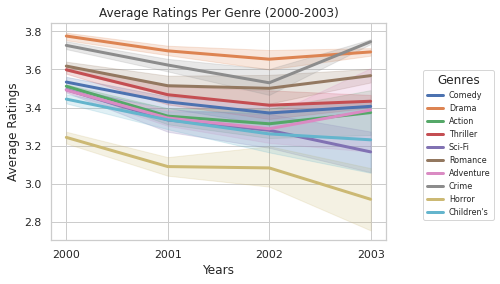

In [167]:
# Ratings Analysis (Overall Trend With Timespan)
# I created this object to perform the chart in "overall_avg_ratings_table". To create this table we need all the ratings with their assigned genres. By doing this we are obtaining all the possible ratings categorised by genre.
overall_avg_ratings_2 = dfratings\
                                .join(dfmovies, dfratings.MovieID==dfmovies.MovieID)\
                                .select("Rating","Genres","Timestamp")

# In this I am using the data above to create a pandas dataframe to create a visual representation which will be more readable for investors.
overall_avg_ratings_graph = overall_avg_ratings_2\
                                    .withColumn("Year",split(overall_avg_ratings_2["Timestamp"], "-").getItem(0))\
                                    .withColumn("Month",split(overall_avg_ratings_2["Timestamp"], "-").getItem(1))\
                                    .select("Year","Month","Rating","Genres")\
                                    .withColumn("Genres", explode(split("Genres","[|]")))\
                                    .groupBy("Year","Month","Genres")\
                                    .agg(
                                        avg(col("Rating")).alias("AverageRatings"))\
                                    .sort("Year","Month")\
                                    .toPandas()

# I am using the same object above to create the chart below, which is the values from the visuals below
print("Chart 5 - Average ratings per genre category (2000-2003)")
overall_avg_ratings_table = overall_avg_ratings_2\
                                                .withColumn("Year",split(overall_avg_ratings_2["Timestamp"], "-").getItem(0))\
                                                .withColumn("Month",split(overall_avg_ratings_2["Timestamp"], "-").getItem(1))\
                                                .select("Year","Month","Rating","Genres")\
                                                .withColumn("Genres", explode(split("Genres","[|]")))\
                                                .groupBy("Year","Month","Genres")\
                                                .agg(
                                                    avg(col("Rating")).alias("AverageRatings"))\
                                                .sort("Year","Month")\
                                                .select("Year","Genres","AverageRatings")\
                                                .groupby("Genres")\
                                                .pivot("Year")\
                                                .avg("AverageRatings").alias("AverageRatings")

overall_avg_ratings_table.select("Genres",round("2000",2).alias("2000"),round("2001",2).alias("2001"),round("2002",2).alias("2002"),round("2003",2).alias("2003")).show()

# Using the same methodology above in section (2.1), I am creating a graph based on the data shown in chart 5.
for i in genres_unique:
    subset = overall_avg_ratings_graph[overall_avg_ratings_graph["Genres"]==i]
    sns.lineplot(data=subset,y="AverageRatings",x="Year",label = i,linewidth = 3)
    
plt.legend(bbox_to_anchor=(1.1, 0.8), loc='upper left', prop={'size': 8}, title = 'Genres')
plt.title('Average Ratings Per Genre (2000-2003)')
plt.xlabel('Years')
plt.ylabel('Average Ratings')
plt.savefig("test2.svg", format="svg")
print("")

**The Overall trend in all genre categories has experienced a downhill trend in their ratings from the past 4 years.**

**Following the graph above, we could highlight that genres such as Adventure and Crime, have experienced an increase in their ratings from 2002-2003. Maybe their are gaining traction, however we would need the dates on the releases of films to do a deeper analysis on this section.**

**It is worth noticing the enormous decrease in horror movies ratings. Although other genre categories have decreased if we compare 2000 until 2003, they remain fairly stable in their ratings along the years. This hasn't been the case for horror movies and therefore the company should devote some effort in solving this issue.**

### (2.3) Analysing users usability of the platform with "dfratings"

> *- How many movies each user watches per year and what is the overal trend along the years? Is the company increasing the users usage of the platform?*

In [11]:
# I am creating the base object that will be needed to create charts 6 and 7
platformusability = dfratings\
                        .withColumn("Date", to_date("Timestamp"))\
                        .select("UserID","MovieID","Rating","Date")
platformusability = platformusability\
                        .withColumn("Year", split(platformusability["Date"], "-").getItem(0))\
                        .withColumn("Month", split(platformusability["Date"], "-").getItem(1))

In [88]:
print("Chart 6 - Descriptive analysis on movie count per year")
platformusability\
            .select("Year",col("MovieID").alias("MovieCount"),col("UserID").alias("DifferentUserIDs"))\
            .groupBy("Year")\
            .agg(
                count("MovieCount").alias("MovieCount"),
                countDistinct("MovieCount").alias("DistinctMovieCount"),
                countDistinct("DifferentUserIDs").alias("DistinctUserIDs"))\
            .withColumn("AvgMoviesPerUser(PerYear)",round(col("MovieCount")/col("DistinctUserIDs")))\
            .sort("Year")\
            .show()

print("Chart 7 - Descriptive analysis on movie count per year and month (Checking if there is a seasonal trend)")
platformusability\
            .select("Year","Month",col("MovieID").alias("MovieCount"),col("UserID").alias("DifferentUserIDs"))\
            .groupBy("Year","Month")\
            .agg(
                count("MovieCount").alias("MovieCount"),
                countDistinct("MovieCount").alias("DistinctMovieCount"),
                countDistinct("DifferentUserIDs").alias("DistinctUserIDs"))\
            .withColumn("AvgMoviesPerUser(PerMonth)",round(col("MovieCount")/col("DistinctUserIDs")))\
            .sort("Year","Month")\
            .show(50)

Chart 6 - Descriptive analysis on movie count per year
+----+----------+------------------+---------------+-------------------------+
|Year|MovieCount|DistinctMovieCount|DistinctUserIDs|AvgMoviesPerUser(PerYear)|
+----+----------+------------------+---------------+-------------------------+
|2000|    904721|              3678|           6034|                    150.0|
|2001|     68094|              3289|           1070|                     64.0|
|2002|     24046|              2971|            565|                     43.0|
|2003|      3348|              1601|            178|                     19.0|
+----+----------+------------------+---------------+-------------------------+

Chart 7 - Descriptive analysis on movie count per year and month (Checking if there is a seasonal trend)
+----+-----+----------+------------------+---------------+--------------------------+
|Year|Month|MovieCount|DistinctMovieCount|DistinctUserIDs|AvgMoviesPerUser(PerMonth)|
+----+-----+----------+------------

**As it is pretty evident, something it is happening to the users within the platform. At the very beginning, there was a mayor excitment by the users and the average movies per user was really high. However, at the very beginning of 2001, users started to decrease the amount of movies they watched per year and per month.**

**We can say that there is a problem, however more data is needed in order to identify the reasons for the decrease in average movies per user and the number of users using the platform.**

> *This decrease could befor numerous reasons (1) there are no more new movies in the platform, causing people to leave. (2) Consumer profiles have changed in the last 3 years. (3) The streaming company is doing something wrong in their infrastructure that is affecting their customers.*

---

## (3) "Dfusers" Dataframe Analysis

### (3.1) Identifying different consumer profiles using the platform

> *- How many users do we have working, studying or unemployed? Is the split equally distributed or is there an unequal distribution between the different categories?*

> *- How is the age distribution between the different occupation categories?*

Chart 8 - Occupation Categories division in the platform
+------------------+----------+---------------+
|OccupationCategory|UsersCount|PercentageSplit|
+------------------+----------+---------------+
|  Actively Working|      4872|           81.0|
|          Studying|       954|           16.0|
|       Not Working|       214|            4.0|
+------------------+----------+---------------+

Chart 9 - Age Distribution in the platform
+--------+----------+---------------+
|     Age|UsersCount|PercentageSplit|
+--------+----------+---------------+
|   25-34|      2096|           35.0|
|   35-44|      1193|           20.0|
|   18-24|      1103|           18.0|
|   45-49|       550|            9.0|
|   50-55|       496|            8.0|
|     56+|       380|            6.0|
|Under 18|       222|            4.0|
+--------+----------+---------------+



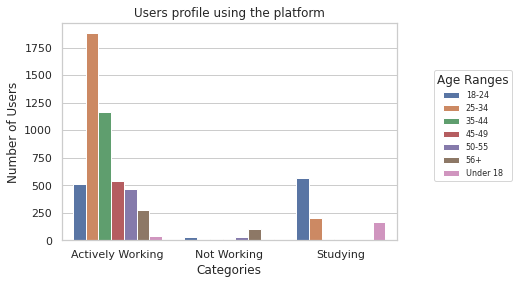

In [168]:
# This section is used to build the graph below.
profiling = dfusers\
                    .withColumn('Occupation_2',
                                    when((col('Occupation') == "unemployed") | (col('Occupation') == "retired"), "Not Working")
                                    .when((col('Occupation') == "K-12 student") | (col('Occupation') == "college/grad student"), "Studying")
                                    .otherwise("Actively Working"))\
                    .groupBy("Occupation_2","Age")\
                    .count()\
                    .sort("Age","Occupation_2")\
                    .toPandas()

sns.barplot(x="Occupation_2",y="count",data=profiling,hue="Age")

plt.legend(bbox_to_anchor=(1.1, 0.8), loc='upper left', prop={'size': 8}, title = 'Age Ranges')
plt.title('Users profile using the platform')
plt.xlabel('Categories')
plt.ylabel('Number of Users')
plt.savefig("test3.svg", format="svg")

# I am using "dfusers" to create 2 different charts by implementing different techniques. 
print("Chart 8 - Occupation Categories division in the platform")
dfusers\
        .withColumn('OccupationCategory',
                        when((col('Occupation') == "unemployed") | (col('Occupation') == "retired"), "Not Working")
                        .when((col('Occupation') == "K-12 student") | (col('Occupation') == "college/grad student"), "Studying")
                        .otherwise("Actively Working"))\
        .groupBy("OccupationCategory")\
        .count()\
        .withColumnRenamed("count", "UsersCount")\
        .withColumn("PercentageSplit", round((col("UsersCount")/sum("UsersCount").over(Window.partitionBy()))*100))\
        .sort(desc("PercentageSplit"))\
        .show()

print("Chart 9 - Age Distribution in the platform")
dfusers\
        .withColumn('OccupationCategory',
                        when((col('Occupation') == "unemployed") | (col('Occupation') == "retired"), "Not Working")
                        .when((col('Occupation') == "K-12 student") | (col('Occupation') == "college/grad student"), "Studying")
                        .otherwise("Actively Working"))\
        .groupBy("Age")\
        .count()\
        .withColumnRenamed("count", "UsersCount")\
        .withColumn("PercentageSplit", round((col("UsersCount")/sum("UsersCount").over(Window.partitionBy()))*100))\
        .sort(desc("PercentageSplit"))\
        .show()

**According to the data in chart 9, almost 50% of the platform users are between the ages of 25-44, these individuals are actively working and a small segment are studying (6% from the 50% of users between 25-44).**

**Another point which is worth mentioning is the importance of users within the segment 18-24. We shouldn't discourage the 18-24 segment, this segment could be a potential one throughout the years (In order to partly demonstate my point, let's analyse the most frequent users in the platform and check if there are various users in the 18-24 age bracket)**

### (3.2) Closer look at the actively working occupation category

> *- What is the percentage split of the "Active workers" in the occupation category? Which occupation category is highly interested in the platform?*

In [90]:
# Create chart to analyse Active Users - I am making a categorisation that will simplify the data analysis 
# "Occupation" has been segmented into three main categories - (1) Active workers (2) Students (3) Unemployed workers
print("Chart 10 - Occupation split in the 'actively working' category")
dfusers\
        .withColumn('OccupationCategory',
            when((col('Occupation') == "unemployed") | (col('Occupation') == "retired"), "Not Working")
            .when((col('Occupation') == "K-12 student") | (col('Occupation') == "college/grad student"), "Studying")
            .otherwise("Actively Working"))\
        .select("Occupation","OccupationCategory")\
        .filter(col("OccupationCategory") == "Actively Working")\
        .groupBy("OccupationCategory","Occupation")\
        .count()\
        .sort(desc("count"))\
        .withColumnRenamed("count", "UsersCount")\
        .withColumn("PercentageSplit", round((col("UsersCount")/sum("UsersCount").over(Window.partitionBy()))*100))\
        .show()

Chart 10 - Occupation split in the 'actively working' category
+------------------+--------------------+----------+---------------+
|OccupationCategory|          Occupation|UsersCount|PercentageSplit|
+------------------+--------------------+----------+---------------+
|  Actively Working|               other|       711|           15.0|
|  Actively Working|executive/managerial|       679|           14.0|
|  Actively Working|   academic/educator|       528|           11.0|
|  Actively Working| technician/engineer|       502|           10.0|
|  Actively Working|          programmer|       388|            8.0|
|  Actively Working|     sales/marketing|       302|            6.0|
|  Actively Working|              writer|       281|            6.0|
|  Actively Working|              artist|       267|            5.0|
|  Actively Working|       self-employed|       241|            5.0|
|  Actively Working|  doctor/health care|       236|            5.0|
|  Actively Working|      clerical/admin

**As we can see in chart, those occupations that have more time tend to use the platform the most.**

### (3.3) Top 15% users occupation identification

> *- Analyse which occupation do our top 15% most frequent users and to which age range do they correspond? Check if students between 18-24 is a good target to focus on for future strategy*

Chart 11 - Occupation Identification & Age: Top 15% of Users
+----+----------------------+-------+--------------+
|    | Occupation           | Age   |   UsersCount |
+====+======================+=======+==============+
|  0 | college/grad student | 18-24 |            8 |
+----+----------------------+-------+--------------+
|  1 | other                | 25-34 |            7 |
+----+----------------------+-------+--------------+
|  2 | college/grad student | 25-34 |            5 |
+----+----------------------+-------+--------------+
|  3 | writer               | 25-34 |            4 |
+----+----------------------+-------+--------------+
|  4 | executive/managerial | 35-44 |            4 |
+----+----------------------+-------+--------------+
|  5 | academic/educator    | 25-34 |            4 |
+----+----------------------+-------+--------------+
|  6 | executive/managerial | 25-34 |            4 |
+----+----------------------+-------+--------------+
|  7 | technician/engineer  | 25-34 | 

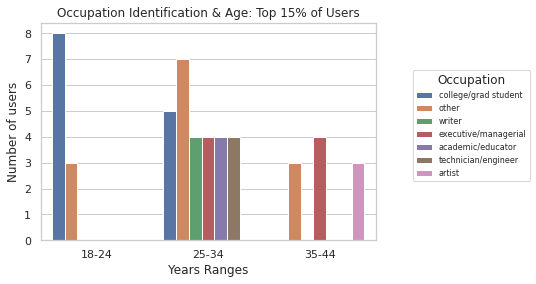

In [169]:
#Top Users (Profile Identification - Top 15% of Users)
# I create two objects in this section, the first one I pretended to enhance and extract the top 15% users from the platform.
# The second one aggrupates all the occupations and finds the most repeated ones from the top 15% users dataframe.
topusers = dfratings\
                    .groupBy("UserID")\
                    .agg(countDistinct(col("MovieID")).alias("DifMovieCount"))\
                    .join(dfusers, dfratings.UserID==dfusers.UserID)\
                    .sort(desc("DifMovieCount"))\
                    .select(dfratings.UserID,"DifMovieCount","Occupation","Age")\
                    .limit(90)

topusers_2 = topusers\
                    .groupBy("Occupation","Age")\
                    .count()\
                    .withColumnRenamed("count","UsersCount")\
                    .sort(desc("UsersCount"))\
                    .filter(col("UsersCount") > 2)\
                    .toPandas()

# Creating chart
print("Chart 11 - Occupation Identification & Age: Top 15% of Users")
print(topusers_2.to_markdown(tablefmt="grid"))

# Creating graph
sns.barplot(x="Age",y="UsersCount",data=topusers_2,hue="Occupation")
plt.legend(bbox_to_anchor=(1.1, 0.8), loc='upper left', prop={'size': 8}, title = 'Occupation')
plt.title('Occupation Identification & Age: Top 15% of Users')
plt.xlabel('Years Ranges')
plt.ylabel('Number of users')
plt.savefig("test4.svg", format="svg")
print("")

**As it has been represented in chart 11, we can confirm that although 18-24 bracket isn't the highest, it would be a great strategy to focus on them and diversify the risk. Heavily investing on the 25-34 it is a good idea, but introducing strategies to capture young clients it isn't a bad idea. They have more time and they can be a long term user in the future.**